# NeuralCora Quickstart

This notebook demonstrates the minimal NeuralCora workflow: configure the CORA dataset loader, instantiate the baseline CNN forecaster, and validate the data→model→metrics pipeline.


## Prerequisites
- Install the project in editable mode: `pip install -e .[dev]`
- Ensure the `data/NY_2013_180_360.nc` and `data/real_land_mask_180_360.nc` files exist (bundled with this repository).
- Install `matplotlib` for history plots and animations: `pip install matplotlib`.


In [1]:
from pathlib import Path
import importlib

from neuralcora.utils import load_config, resolve_device
from neuralcora.datautils import CoraDataModule
from neuralcora.modelzoo import get_model_class
from neuralcora.evaluation import evaluate_metrics
from neuralcora.training import BasicTrainer
import torch

project_root = Path.cwd()
for _ in range(3):
    if (project_root / 'data').exists():
        break
    project_root = project_root.parent

data_path = project_root / 'data/NY_2013_180_360_demo.nc'
mask_path = project_root / 'data/real_land_mask_180_360.nc'
assert data_path.exists(), f'Data file not found: {data_path}'
assert mask_path.exists(), f'Mask file not found: {mask_path}'


In [7]:
import yaml

config = load_config(
    {
        'run_name': 'intro-notebook',
        'data': {
            'dataset_path': str(data_path),
            'mask_path': str(mask_path),
            'input_steps': 1,
            'forecast_steps': 6,
            'stride': 1,
            'batch_size': 2,
            'num_workers': 0,
            'normalization': 'global',
            'split_fractions': {'train': 0.8, 'val': 0.1, 'test': 0.1},
        },
        'model': {
            'name': 'simple_cnn',
            'input_channels': 1,
            'output_channels': 6,
            'hidden_channels': [16, 32],
            'kernel_size': 3,
            'dropout': 0.2,
        },
        'training': {
            'trainer_name': 'basic',
            'epochs': 2,
            'learning_rate': 1e-1,
            'log_interval': 50,
            'device': 'auto',
            'weight_decay': 1e-5,
        },
    }
)
print(config)

# def load_config_from_yaml(path: str):
#     with open(path, "r") as f:
#         return yaml.safe_load(f)

# config_dict = load_config_from_yaml("config.yml")

# # Assuming your `load_config` function takes a dict:
# config = load_config(config_dict)

# print(config)

ExperimentConfig(seed=42, run_name='intro-notebook', data=DataConfig(dataset_name='cora', dataset_path='/Users/yunlong/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/neuralcora/data/NY_2013_180_360_demo.nc', mask_path='/Users/yunlong/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/neuralcora/data/real_land_mask_180_360.nc', input_steps=1, forecast_steps=6, stride=1, normalization='global', stats_path=None, batch_size=2, num_workers=0, split_fractions={'train': 0.8, 'val': 0.1, 'test': 0.1}), model=ModelConfig(name='simple_cnn', input_channels=1, output_channels=6, hidden_channels=[16, 32], kernel_size=3, dropout=0.2), training=TrainingConfig(trainer_name='basic', epochs=2, learning_rate=0.1, weight_decay=1e-05, device='auto', log_interval=50, save_dir='runs', gradient_clip_norm=None), notes=None)


> **Note:** The quickstart uses `BasicTrainer` for convenience, which provides `plot_history()` and `visualize_validation_sample()` to inspect training dynamics and forecasts.

In [8]:
datamodule = CoraDataModule(config.data)
datamodule.setup(stage='fit')
train_loader = datamodule.train_dataloader()
batch = next(iter(train_loader))
inputs = batch['inputs']
targets = batch['targets']
input_indices = batch['input_start_index'].tolist()
target_indices = batch['target_start_index'].tolist()
print(f'Inputs shape: {tuple(inputs.shape)}')
print(f'Targets shape: {tuple(targets.shape)}')
print(f'Input windows start at hours {input_indices}')
print(f'Forecast windows begin at hours {target_indices}')


/Users/yunlong/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/neuralcora/neuralcora/utils/normalization.py:25: RuntimeWarning: Mean of empty slice
  mean = float(np.nanmean(array))
/opt/anaconda3/envs/yl-demo-0917/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Inputs shape: (2, 1, 180, 360)
Targets shape: (2, 6, 180, 360)
Input windows start at hours [321, 351]
Forecast windows begin at hours [322, 352]


In [9]:
model_cls = get_model_class(config.model.name)
model = model_cls(
    input_channels=config.model.input_channels or config.data.input_steps,
    output_channels=config.model.output_channels or config.data.forecast_steps,
    hidden_channels=config.model.hidden_channels,
    kernel_size=config.model.kernel_size,
    dropout=config.model.dropout,
)
trainer = BasicTrainer(config.training)
history = trainer.fit(model, datamodule)
history

/Users/yunlong/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/neuralcora/neuralcora/utils/normalization.py:25: RuntimeWarning: Mean of empty slice
  mean = float(np.nanmean(array))
/opt/anaconda3/envs/yl-demo-0917/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Epoch 1 Step 50/199 - Loss: 0.1038
Epoch 1 Step 100/199 - Loss: 0.1728
Epoch 1 Step 150/199 - Loss: 0.1949
Epoch 1 Summary - train_loss: 0.1797 (norm 0.1797), val_loss: 0.0775 (norm 0.0775)
Epoch 2 Step 50/199 - Loss: 0.2013
Epoch 2 Step 100/199 - Loss: 0.1438
Epoch 2 Step 150/199 - Loss: 0.2753
Epoch 2 Summary - train_loss: 0.1390 (norm 0.1390), val_loss: 0.0777 (norm 0.0777)


[{'epoch': 1,
  'train_mse': 0.1796946264241808,
  'train_mse_normalized': 0.1796946264241808,
  'val_mse': 0.07746843814849853,
  'val_mse_normalized': 0.07746843814849853,
  'val_rmse': 0.27475042045116427,
  'val_metrics': {'rmse': 0.27475042045116427,
   'mae': 0.17930632174015046,
   'bias': -0.015902269147336483,
   'nrmse': 0.13494292736053468,
   'pearson_corr': 0.023126250207424162}},
 {'epoch': 2,
  'train_mse': 0.13895471652398755,
  'train_mse_normalized': 0.13895471652398755,
  'val_mse': 0.07766801789402962,
  'val_mse_normalized': 0.07766801789402962,
  'val_rmse': 0.2753280222415924,
  'val_metrics': {'rmse': 0.2753280222415924,
   'mae': 0.18261425018310548,
   'bias': -0.010384067296981811,
   'nrmse': 0.135259772837162,
   'pearson_corr': 0.021941620111465453}}]

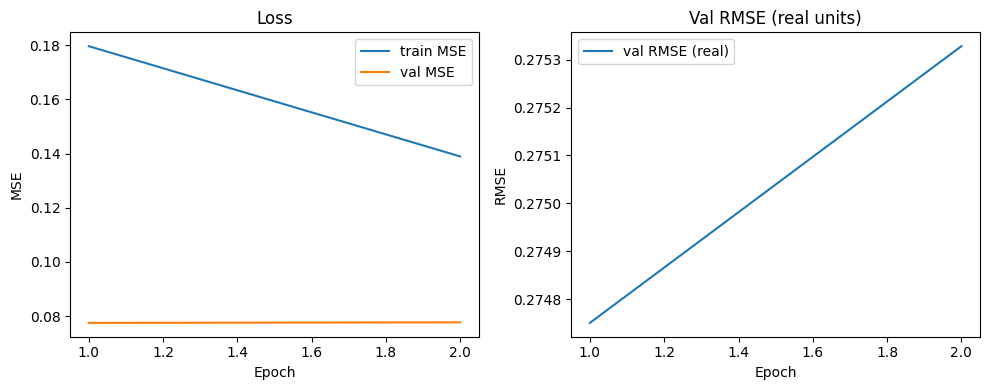

In [10]:
trainer.plot_history()

In [11]:
fig, anim = trainer.visualize_validation_sample()
from IPython.display import HTML
HTML(anim.to_jshtml())

## Next Steps
- Use `neuralcora.run.train` to execute multi-epoch experiments from YAML config files.
- Experiment with deeper CNN architectures or alternative normalization strategies in `config.model`.
- Customize visualization (additional channels, horizons) to inspect coastal surge behaviour across events.
